In [1]:
# Imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc, roc_auc_score
from sklearn import datasets
from sklearn import preprocessing
from sklearn.datasets import load_digits
from numpy import linalg as LA
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from numpy import linalg as LA
from sklearn.metrics import pairwise_distances
from copy import deepcopy
from sklearn.cluster import KMeans
from numba import jit, cuda
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.stats import sem
import warnings
warnings.filterwarnings("ignore")

In [2]:
def compute_margin(X, y, w, b):
    margin = []
    for i in range(y.shape[0]):
        margin.append((y[i]*(np.dot(X[i,:], w)+b))/sqrt(sum(w**2))) 
    if min(margin) >= 0:
        return min(margin)
    return 0

In [3]:
from sklearn.base import BaseEstimator, ClassifierMixin
class RBF_IMA(BaseEstimator, ClassifierMixin):

    # Inicialization of important parameters 
    def __init__(self, n_neurons, eta=0.1, lambda_param=0.01, delta_margin=10^-3,
                 IMA_iterations=20, max_updates=10000, p='2'):
        self.n_neurons = n_neurons              # Neurons of hidden layer osf RBF
        self.eta = eta                          # Learning rate
        self.lambda_param = lambda_param        # Param important of soft margin
        self.delta_margin = delta_margin        # (1 + delta_margin) * fixed margin defines the minimum next margin of IMA
        self.IMA_iterations = IMA_iterations    # Maximum number of iterations of IMA
        self.max_updates = max_updates          # Maximum number of updates in one execution of FMP
        self.w = np.array([])                   # Vector of weights of the last layer of the RBF obtained after the training of the IMA
        self.w_rbf = np.array([])               # Vector of weights of the last layer of the RBF obtained after the normal training of RBF
        self.H = np.array([])                   # H matrix of RBF (obtained with training data)
        self.Z = np.array([])                   # Z matrix of RBF
        self.b = 0
        self.p = p 

    @staticmethod
    @jit(target_backend='cuda')    
    def pdfnvar(pairwise_dist, sigma):
        return np.exp(-pairwise_dist ** 2 / (2 * sigma ** 2))

    # Fixed Margin Algorithm
    @staticmethod
    @jit(target_backend='cuda')    
    def FMP_algorithm(X, y, w_init, b_init, fixed_margin, idx, s, lambda_param, eta, max_updates, p):
        t = 0
        iterations = 0
        w = w_init
        b = b_init
        if p == 'inf':
            norm_w = LA.norm(w, ord=1)
        elif p == '1':
            norm_w = LA.norm(w, ord=np.inf)
        else: # p == 2
            norm_w = sqrt(sum(w**2))
        
        last_t = -1
        lambda_t = 0
        alpha = np.zeros((X.shape[0]))
        while True:
            last_t = t
            e=0
            for k in range(0, y.shape[0]):
                i = int(idx[k])
                if(y[i]*(np.dot(X[i,:], w)+b) <= fixed_margin * norm_w - lambda_param * alpha[i]):
                    if norm_w != 0:
                        lambda_t = 1 - (eta*fixed_margin)/norm_w
                    else:
                        lambda_t = 1
                    alpha = alpha * lambda_t
                    alpha[i] = alpha[i] + eta  
                    if p == 'inf':
                        w = w - eta * (fixed_margin * np.sign(w) - y[i] * X[i,:])
                        norm_w = LA.norm(w, ord=1)
                    elif p == '1':
                        for j in range(len(w)):
                            if abs(w[j]) == norm_w:
                                w[j] = w[j] - eta * (fixed_margin * np.sign(w[j])/sum(np.abs(w) == norm_w) - y[i] * X[i,j])
                            elif abs(w[j]) < norm_w:
                                w[j] = w[j] + eta * (y[i] * X[i,j])
                        norm_w = LA.norm(w, ord=np.inf)
                    else: # p == 2
                        w = w * lambda_t + eta * y[i] * X[i,:]
                        norm_w = sqrt(sum(w**2))
                    b = b + eta*y[i]
                    t += 1
                    e += 1
                    if k > s:
                        s += 1
                        j = s
                    else:
                        j=e
                    idx[k], idx[j] = idx[j], idx[k]
            iterations += 1
            if (t > max_updates or last_t == t):
                break
        if t<= max_updates:
            convergence=1
        else:
            convergence=0
        return w, b, convergence, t, iterations, idx, s

    # IMA Algorithm
    def IM_algorithm(self, X, y):
        self.w = np.ones(self.w_rbf.shape[0]) * 0
        self.ws = [] 
        self.bs = [] 
        self.ws.append(self.w)
        self.bs.append(self.b)
        fixed_margin = 0#compute_margin(X, y, self.w_RBF, self.b)
        t = 0
        convergence = 1
        updates=0
        iterations=0
        margin=[]
        margin.append(fixed_margin)
        idx = np.linspace(0, y.shape[0]-1, y.shape[0])
        s=0
        while convergence==1 and t<self.IMA_iterations:
            w, b, convergence, updates_, iterations_, idx, s = self.FMP_algorithm(X, y, self.w, self.b, fixed_margin, idx, s, self.lambda_param, self.eta, self.max_updates, self.p)
            if convergence == 1:
                self.w = w
                self.b = b
                self.ws.append(self.w)
                self.bs.append(self.b)
            updates += updates_
            iterations += iterations_
            
            if self.p == 'inf':
                norm_w = LA.norm(w, ord=1)
            elif self.p == '1':
                norm_w = LA.norm(w, ord=np.inf)
            else: # p == 2
                norm_w = sqrt(sum(w**2))
            
            gamma1 = []
            gamma2 = []
            for i in range(0, y.shape[0]):
                if y[i] == 1:
                    gamma1.append((y[i]*(np.dot(X[i], self.w)+self.b))/norm_w)
                else:
                    gamma2.append((y[i]*(np.dot(X[i], self.w)+self.b))/norm_w)
            gamma1 = np.array(gamma1)
            gamma2 = np.array(gamma2)
            gamma1 = gamma1[gamma1>=0]
            gamma2 = gamma2[gamma2>=0]
            if len(gamma1) == 0:
                min_gamma1 = 0
            else:
                min_gamma1 = min(gamma1)
            if len(gamma2) == 0:
                min_gamma2 = 0
            else:
                min_gamma2 = min(gamma2)
            fixed_margin = max([(min_gamma1 + min_gamma2)/2, (1+self.delta_margin)*fixed_margin])
            margin.append(compute_margin(X, y, self.w, self.b))
            t += 1
        return t, updates, iterations, margin

    # Function that manage the training of IMA RBF
    def fit(self, X, y):
        N = X.shape[0] # number of samples
        n = X.shape[1] # samples dimension
        # Applying K-mean to separate the clusters:
        kmeans = KMeans(n_clusters=self.n_neurons).fit(X)
        # Capture the centers:
        self.centers = kmeans.cluster_centers_

        pairwise_dist = pairwise_distances(X, self.centers)

        self.sigma = np.mean(np.mean(pairwise_dist, axis=1))
        
        self.H = self.pdfnvar(pairwise_dist, self.sigma)

        #self.H = np.hstack((self.H, np.ones((self.H.shape[0], 1))))

        self.w_rbf = np.dot(np.linalg.pinv(self.H), y)
        
        iterations_IMA, updates, iterations, margin = self.IM_algorithm(self.H, y) 
        
        return iterations_IMA, updates, iterations, margin
            
    # Function to apply IMA RBF model
    def predict(self, X, use_IMA_w=True):
        pairwise_dist = pairwise_distances(X, self.centers)
        H = self.pdfnvar(pairwise_dist, self.sigma)
        #H = np.hstack((H, np.ones((H.shape[0], 1))))
        if use_IMA_w == True:
            y_predicted = np.sign(np.dot(H, self.w) + self.b)
        else:
            y_predicted = np.sign(np.dot(H,  self.w_rbf))
        y_predicted[y_predicted==0]=-1
        return y_predicted

In [4]:
def plot_decision_border(X, y, clf, use_IMA_w, fig, pos, title):
    ax = fig.add_subplot(pos)
    # decision surface for logistic regression on a binary classification dataset
    min1, max1 = X[:, 0].min()-0.5, X[:, 0].max()+0.5
    min2, max2 = X[:, 1].min()-0.5, X[:, 1].max()+0.5
    # define the x and y scale
    x1grid = np.arange(min1, max1, 0.1)
    x2grid = np.arange(min2, max2, 0.1)
    # create all of the lines and rows of the grid
    xx, yy = np.meshgrid(x1grid, x2grid)
    # flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    # horizontal stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))
    #grid = normalizer.transform(grid)
    # make predictions for the grid
    yhat=(clf.predict(grid, use_IMA_w))
    yhat=np.array(yhat)
    # reshape the predictions back into a grid
    zz = yhat.reshape(xx.shape)
    # plot the grid of x, y and z values as a surface
    plt.contourf(xx, yy, zz, cmap='RdBu', alpha=0.7)
    # create scatter plot for samples from each class
    plt.scatter(X[:, 0], X[:, 1], cmap='RdBu', c=y, edgecolor='black')
    # show the plot
    plt.title(title, fontweight="bold")  

In [5]:
def plots(X, y, p, eta=0.01, lambda_param=0.01):
    train_accuracy_RBF = 0
    clf = RBF_IMA(n_neurons=p, eta=eta, lambda_param=lambda_param, delta_margin=10^-3, IMA_iterations=20, max_updates=1000000, p='2')
    iterations_IMA, updates, iterations_FMP, margin  = clf.fit(X, y)
    fig = plt.figure(figsize=(11,5))
    plot_decision_border(X, y, clf, False, fig, 121, "Borda de decisão gerada pelo modelo RBFNN")
    plot_decision_border(X, y, clf, True, fig, 122, "Borda de decisão gerada pelo modelo IM-RBFNN" )
    

In [6]:
def plot_margin_evolution(m):
    avg_margins = []
    sem_margins = []
    for i in range(len(m[0])):
        margins = []
        for j in range(len(m)):
            margins.append(m[j][i]) 
        avg_margins.append(np.mean(margins))
        sem_margins.append(sem(margins))
    x = np.array(range(len(avg_margins)))
    plt.figure(1)
    plt.plot(x, avg_margins)
    plt.grid()
    plt.figure(2)
    plt.errorbar(x, avg_margins, sem_margins, color = 'blue', marker='s', capsize=5)
    plt.xlabel("IMA Iterations")
    plt.ylabel("Margin Value")
    plt.xticks(np.linspace(0,20,21))
    plt.grid()

In [46]:
def results(X, y, p, lambda_param=0.1):
    n_splits = 10
    k_fold = StratifiedKFold(n_splits=n_splits, shuffle=True)
    accuracy_RBF_IM = np.zeros(n_splits)
    accuracy_RBF = np.zeros(n_splits)
    margin_IM_RBF = np.zeros(n_splits)
    margin_RBF = np.zeros(n_splits)
    auc_IM_RBF = np.zeros(n_splits)
    auc_RBF = np.zeros(n_splits)
    margins=[]
    
    k_fold = StratifiedKFold(n_splits=n_splits, shuffle=True)
    i = 0
    for train_indices, test_indices in k_fold.split(X, y):
        clf = RBF_IMA(n_neurons=p, eta=0.1, lambda_param=lambda_param, delta_margin=10^-3, IMA_iterations=20, max_updates=100000, p='2')
        iterations_IMA, updates, iterations_FMP, margin = clf.fit(X[train_indices], y[train_indices])
        margins.append(margin)
        y_hat = clf.predict(X[test_indices])
        auc_IM_RBF[i] = roc_auc_score(y[test_indices], y_hat)
        accuracy_RBF_IM[i] = accuracy_score(y[test_indices], y_hat)
        y_hat = clf.predict(X[test_indices], False)
        auc_RBF[i] = roc_auc_score(y[test_indices], y_hat)
        accuracy_RBF[i] = accuracy_score(y[test_indices], y_hat)
        margin_IM_RBF[i] = compute_margin(clf.H, y[train_indices], clf.w, clf.b)
        margin_RBF[i] = compute_margin(clf.H, y[train_indices], clf.w_rbf, 0)
        i +=1
    
    print(f"*********** Resultado IM RBF com {p} neurônios na camada escondida **************")
    print("Acc: " + '{:.4f}'.format(accuracy_RBF_IM.mean()) + "+/-" + '{:.4f}'.format(accuracy_RBF_IM.std()))
    print("Margin: " + '{:E}'.format(margin_IM_RBF.mean()) + "+/-" + '{:E}'.format(margin_IM_RBF.std()))
    print("AUC: " + '{:.4f}'.format(auc_IM_RBF.mean()) + "+/-" + '{:.4f}'.format(auc_IM_RBF.std()))
    print(f"IMA iterations: {iterations_IMA}")

    print(f"*********** Resultado RBF com {p} neurônios na camada escondida **************")
    print("Acc: " + '{:.4f}'.format(accuracy_RBF.mean()) + "+/-" + '{:.4f}'.format(accuracy_RBF.std()))
    print("Margin: " + '{:E}'.format(margin_RBF.mean()) + "+/-" + '{:E}'.format(margin_RBF.std()))
    print("AUC: " + '{:.4f}'.format(auc_RBF.mean()) + "+/-" + '{:.4f}'.format(auc_RBF.std()))
    return margins

In [51]:
spirals_dataset = pd.read_csv('~/Documents/UFMG/Mastering/article/data sets/spirals/spirals.csv')
y = spirals_dataset["classe"].astype(int).to_numpy()
y[y==2] = -1
X = spirals_dataset.iloc[:,0:2].astype(float).to_numpy()
m = results(X, y, 100)

*********** Resultado IM RBF com 100 neurônios na camada escondida **************
Acc: 0.9900+/-0.0077
Margin: 0.000000E+00+/-0.000000E+00
AUC: 0.9900+/-0.0077
IMA iterations: 20
*********** Resultado RBF com 100 neurônios na camada escondida **************
Acc: 0.9990+/-0.0030
Margin: 1.036781E-14+/-3.102420E-14
AUC: 0.9990+/-0.0030


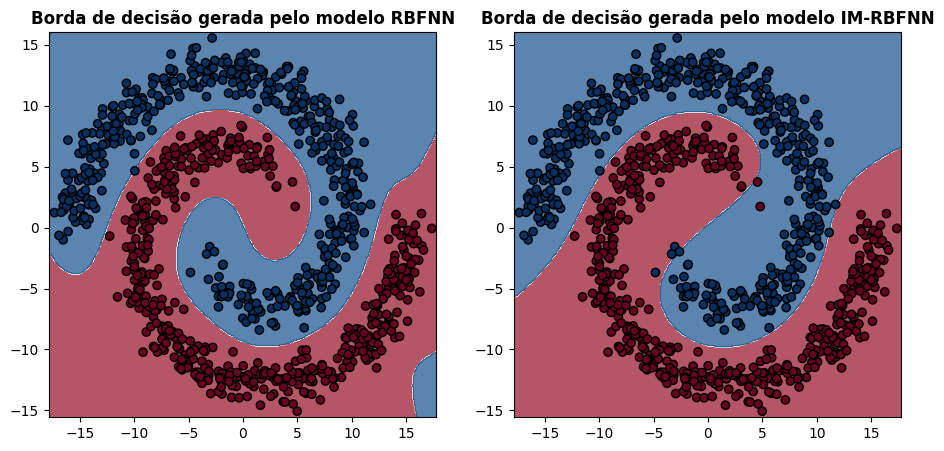

In [9]:
plots(X, y, 100, eta=0.1)

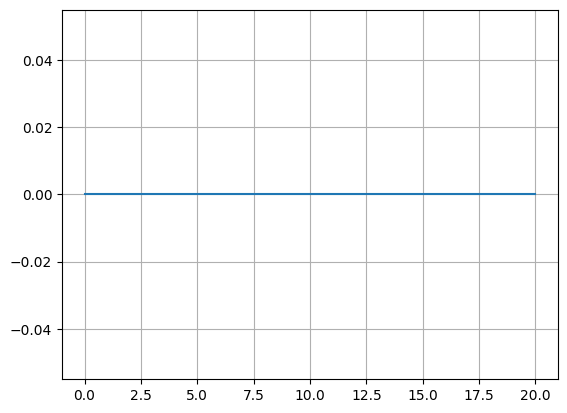

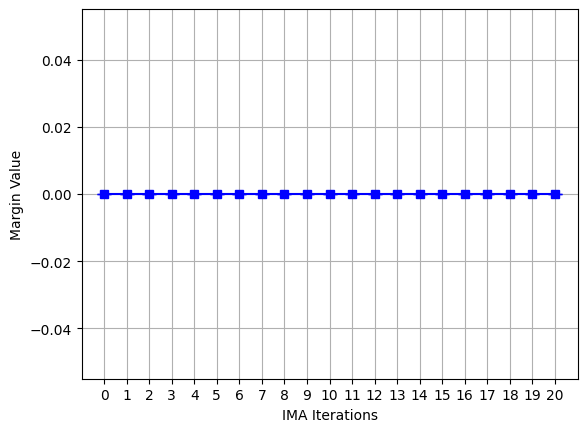

In [10]:
plot_margin_evolution(m)

In [48]:
from sklearn.datasets import make_blobs
centers = [[-2,2],[-2,-2],[2,-2],[2,2]]
X, y = make_blobs(n_samples = 1000, n_features=2, centers=centers, cluster_std=0.6, random_state=100)
y[y%2!=0]=1
y[y%2==0]=-1
m = results(X, y, 100)

*********** Resultado IM RBF com 100 neurônios na camada escondida **************
Acc: 1.0000+/-0.0000
Margin: 2.675988E-02+/-1.320325E-02
AUC: 1.0000+/-0.0000
IMA iterations: 20
*********** Resultado RBF com 100 neurônios na camada escondida **************
Acc: 0.9990+/-0.0030
Margin: 5.996063E-13+/-3.702085E-13
AUC: 0.9990+/-0.0030


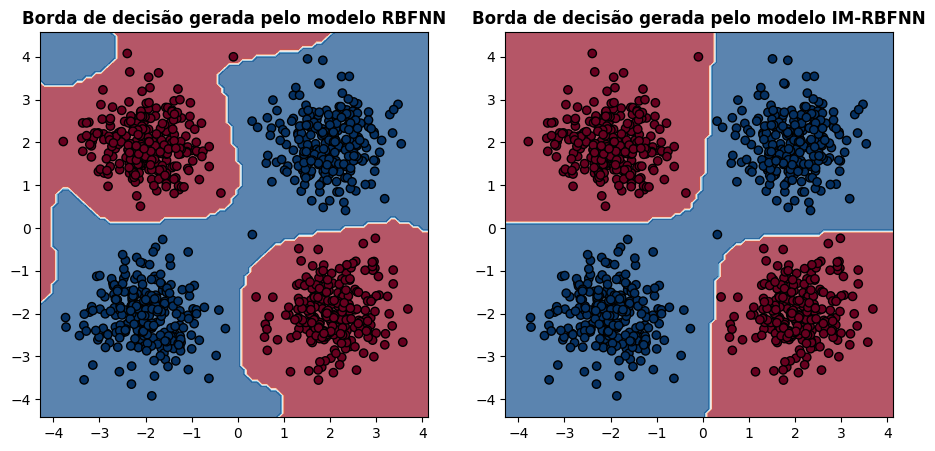

In [21]:
plots(X, y, 100)

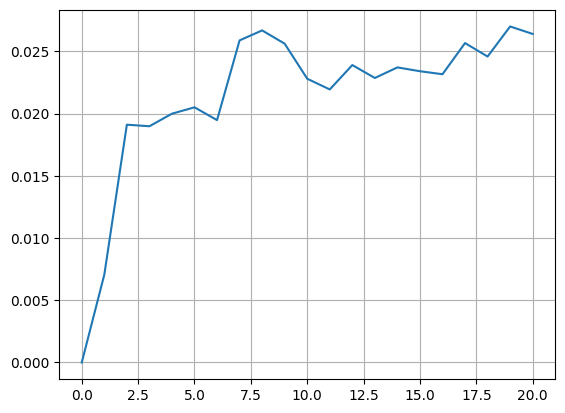

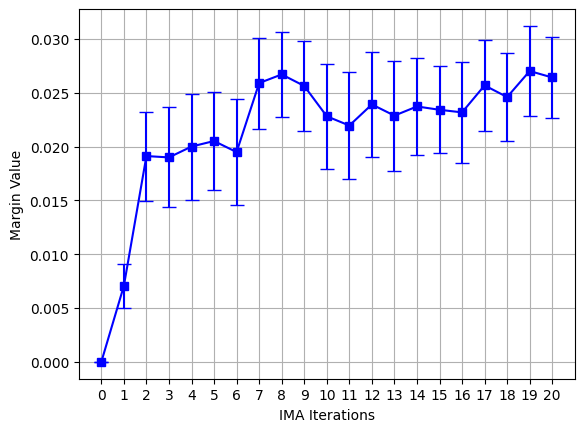

In [38]:
plot_margin_evolution(m)

In [49]:
X, y = datasets.make_circles(n_samples=1000, factor=0.4, noise=0.07)
y[y%2!=0]=1
y[y%2==0]=-1
m = results(X, y, 100)

*********** Resultado IM RBF com 100 neurônios na camada escondida **************
Acc: 1.0000+/-0.0000
Margin: 2.860683E-01+/-3.258797E-02
AUC: 1.0000+/-0.0000
IMA iterations: 20
*********** Resultado RBF com 100 neurônios na camada escondida **************
Acc: 1.0000+/-0.0000
Margin: 8.410379E-13+/-2.959195E-13
AUC: 1.0000+/-0.0000


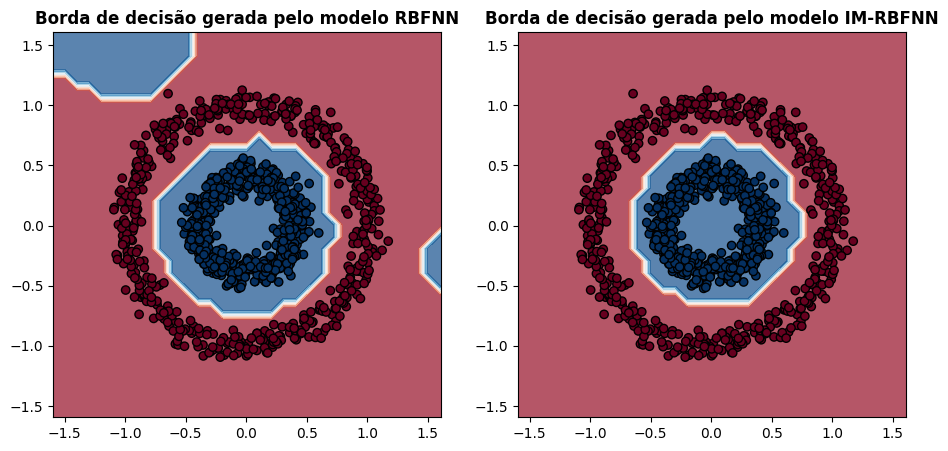

In [15]:
plots(X, y, 100)

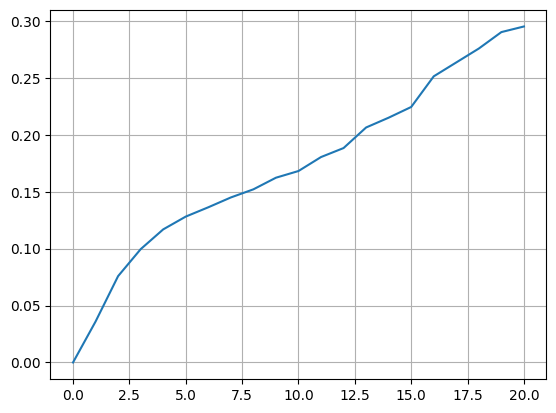

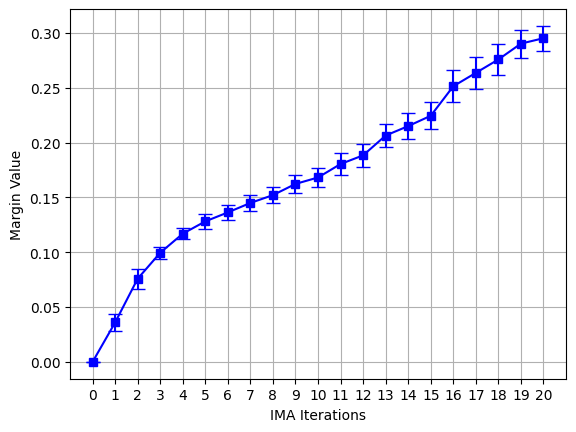

In [40]:
plot_margin_evolution(m)

In [52]:
from sklearn.datasets import make_blobs
centers = [[-2,0],[2,0]]
X, y = make_blobs(n_samples = 1000, n_features=2, centers=centers, cluster_std=0.6)
y[y%2!=0]=1
y[y%2==0]=-1
m = results(X, y, 100)

*********** Resultado IM RBF com 100 neurônios na camada escondida **************
Acc: 1.0000+/-0.0000
Margin: 4.550298E-01+/-4.720212E-02
AUC: 1.0000+/-0.0000
IMA iterations: 20
*********** Resultado RBF com 100 neurônios na camada escondida **************
Acc: 0.9940+/-0.0066
Margin: 3.734720E-13+/-2.641543E-13
AUC: 0.9940+/-0.0066


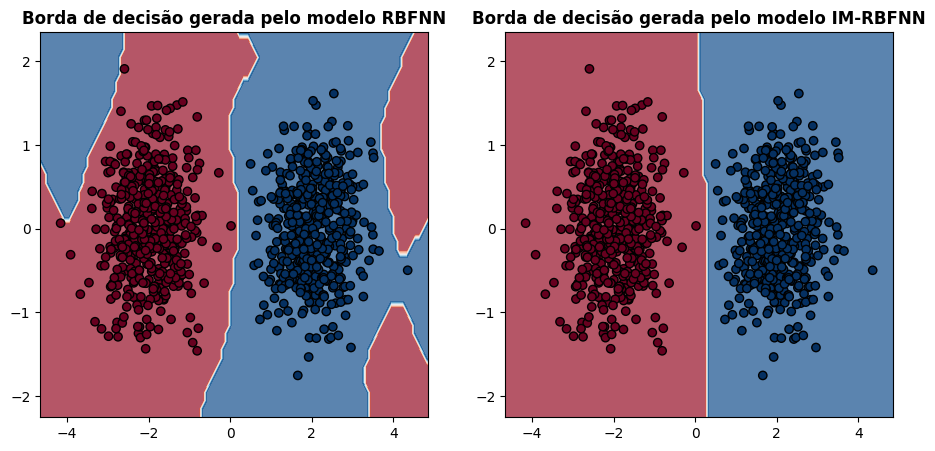

In [18]:
plots(X, y, 100)

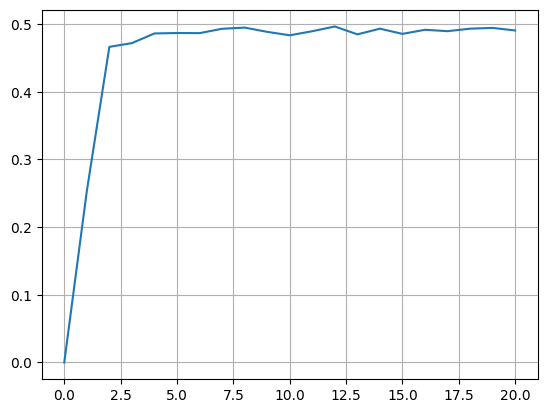

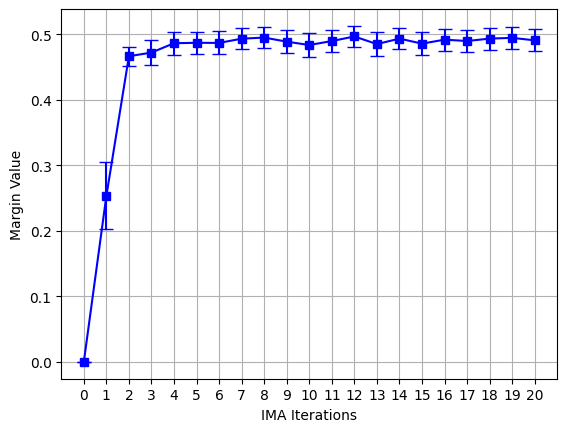

In [42]:
plot_margin_evolution(m)